# Fit a line to data

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import alabi
from alabi.core import SurrogateModel
import alabi.visualization as vis
from functools import partial

### Generate some synthetic data from the model

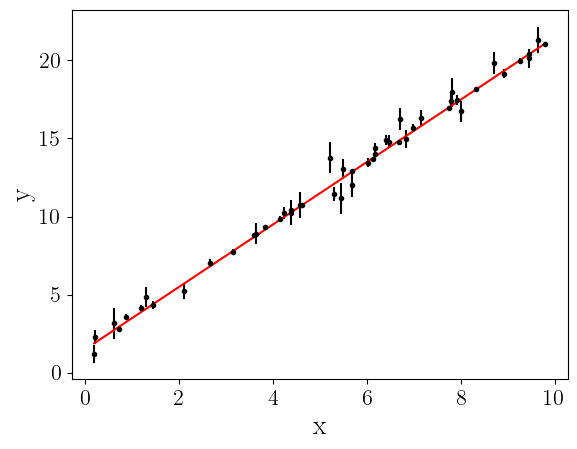

In [7]:
a_true = 2.0
b_true = 1.5

# Define the bounds for the input (a and b)
bounds = [(1.5, 2.5), (1, 2)]

np.random.seed(0)
x = np.sort(10*np.random.rand(50))
yerr = np.random.rand(50)
y = a_true*x + b_true + yerr*np.random.randn(50)

plt.errorbar(x, y, yerr=yerr, fmt="k.")
plt.plot(x, a_true*x + b_true, "r-", label="True line")
plt.xlabel("x", fontsize=20)
plt.ylabel("y", fontsize=20)
plt.show()

### Define the likelihood function

In [8]:
def lnlike(theta, x, y, yerr):
    a, b = theta  
    ypred = a * x + b
    lnl = -0.5 * np.sum(((y - ypred)**2) / (yerr**2))
    return lnl

lnl = partial(lnlike, x=x, y=y, yerr=yerr)

In [9]:
lnl([a_true, b_true])

np.float64(-30.033423563056278)

### Train the surrogate model

In [ ]:
# Create the surrogate model
sm = SurrogateModel(lnlike_fn=lnl, bounds=bounds, savedir="results/linear_fit")

# Initialize samples
sm.init_samples(ntrain=200, sampler="sobol")  

print("Data diagnostics:")
print(f"  theta shape: {sm._theta.shape}")
print(f"  y shape: {sm._y.shape}")
print(f"  y range: [{sm._y.min():.3f}, {sm._y.max():.3f}]")
print(f"  y std: {sm._y.std():.3f}")

gp_kwargs = {"kernel": "ExpSquaredKernel", 
             "fit_amp": True, 
             "fit_mean": True, 
             "fit_white_noise": False, 
             "white_noise": -8,
             "gp_opt_method": "l-bfgs-b",
             "gp_scale_rng": [-2,1],
             "optimizer_kwargs": {"max_iter": 50, "xatol": 1e-3, "fatol": 1e-3, "adaptive": True}}

al_kwargs={"algorithm": "bape", 
           "gp_opt_freq": 20, 
           "obj_opt_method": "nelder-mead", 
           "nopt": 1,
           "optimizer_kwargs": {"max_iter": 50, "xatol": 1e-3, "fatol": 1e-2, "adaptive": True}}

# Initialize the Gaussian Process (GP) surrogate model
sm.init_gp(**gp_kwargs)   

# Train the GP surrogate model with conservative settings
sm.active_train(niter=100, **al_kwargs)

In [11]:
sm.true_log_likelihood([a_true, b_true]), sm.surrogate_log_likelihood([a_true, b_true])

(np.float64(-30.033423563056278), np.float64(-30.03630764913396))

### Plot some diagnostics

Plotting true function contours 2D...
Saving to  results/linear_fit/true_function_2D.png
Saving to  results/linear_fit/true_function_2D.png


Plotting true function contours 2D...
Saving to  results/linear_fit/true_function_2D.png
Saving to  results/linear_fit/true_function_2D.png


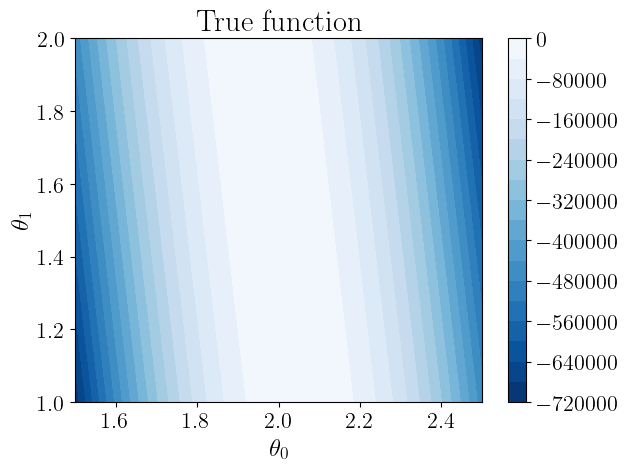

In [12]:
sm.plot(plots=["true_fn_2D"])

Plotting gp fit 2D...


Plotting gp fit 2D...


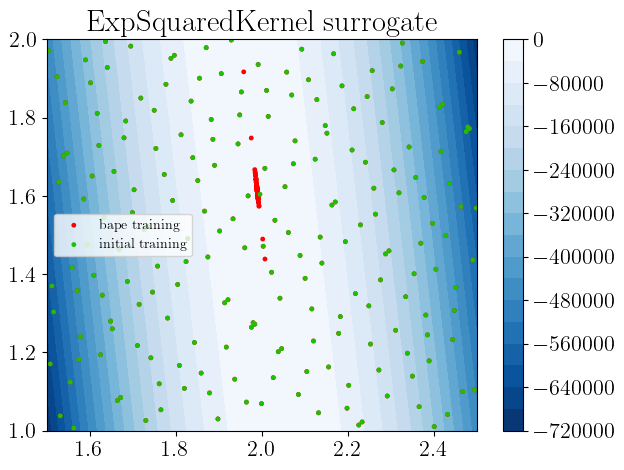

In [13]:
sm.plot(plots=["gp_fit_2D"])

Plotting objective function contours 2D...


Plotting objective function contours 2D...


Saving to  results/linear_fit/objective_function.png


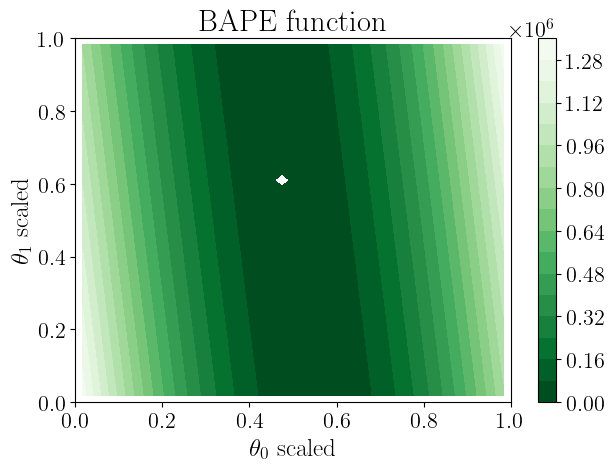

In [14]:
sm.plot(plots=["obj_fn_2D"])

Saving to  results/linear_fit/true_function.png


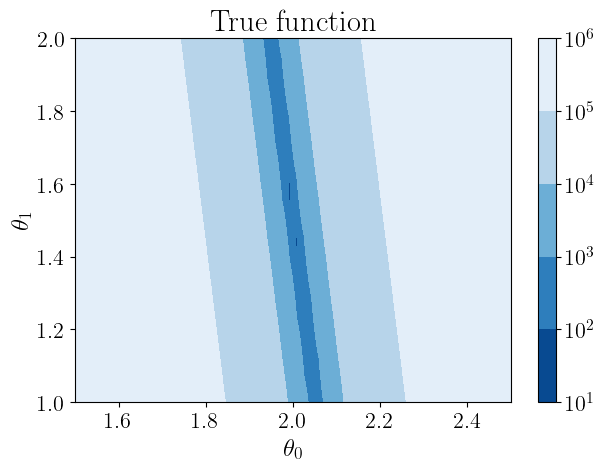

In [15]:
nll_true = lambda *args: -sm.true_log_likelihood(*args)
vis.plot_contour_2D(nll_true, sm.bounds, sm.savedir, "true_function.png",  title="True function", ngrid=60, 
                    xlabel=sm.param_names[0], ylabel=sm.param_names[1], log_scale=True)

Saving to  results/linear_fit/surrogate_model.png


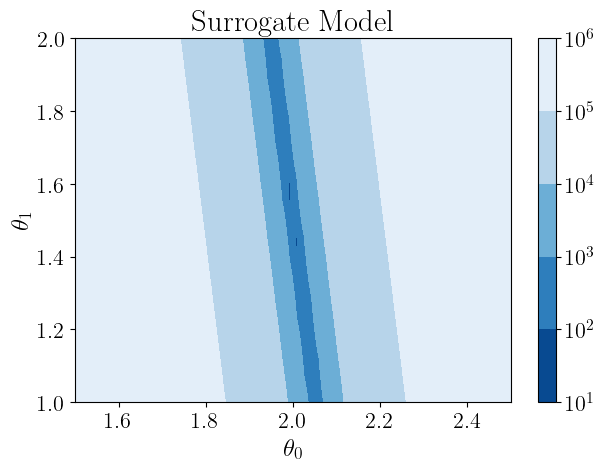

In [16]:
nll_pred = lambda *args: -sm.surrogate_log_likelihood(*args)
vis.plot_contour_2D(nll_pred, sm.bounds, sm.savedir, "surrogate_model.png", title="Surrogate Model", ngrid=60, 
                    xlabel=sm.param_names[0], ylabel=sm.param_names[1], log_scale=True)

Now let's compare how MCMC samples from the true function compare to samples from the `alabi` surrogate model:

In [ ]:
sm.run_dynesty(like_fn=sm.true_log_likelihood)
sm.run_dynesty(like_fn=sm.surrogate_log_likelihood)

Saving to  results/linear_fit/mcmc_comparison_true posterior_surrogate posterior.png


Saving to  results/linear_fit/mcmc_comparison_true posterior_surrogate posterior.png


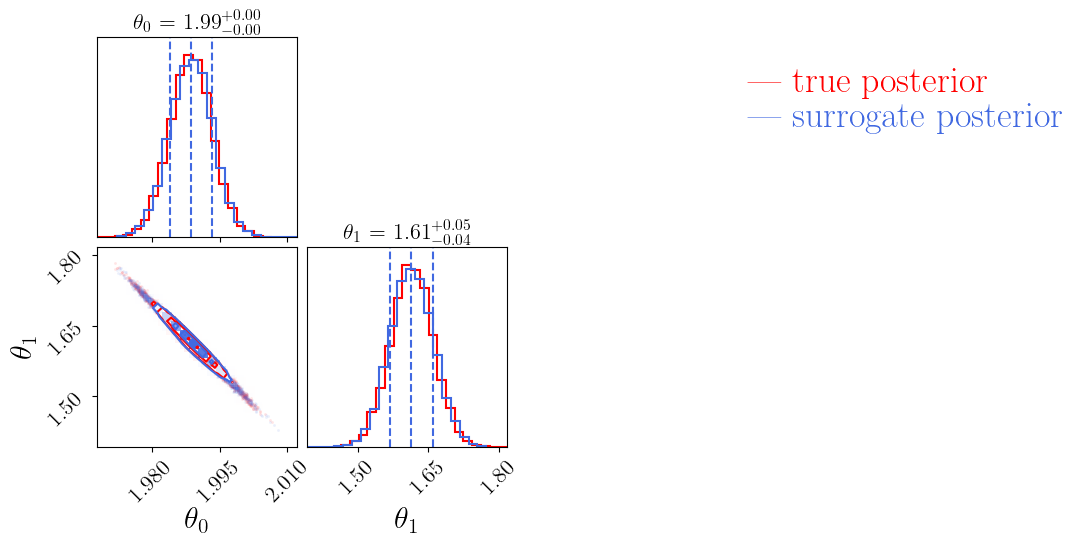

In [19]:
vis.plot_mcmc_comparison(sm.dynesty_samples_true, sm.dynesty_samples_surrogate,
                     param_names=sm.param_names, lw=1.5, colors=["red", "royalblue"],
                     name1="true posterior", name2="surrogate posterior",
                     savedir=sm.savedir, savename="mcmc_comparison.png");

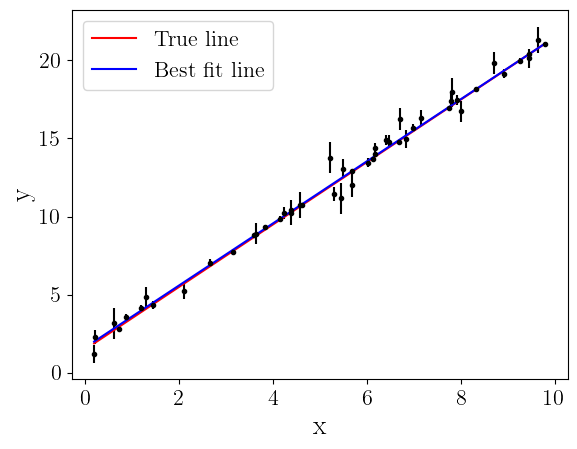

In [20]:
afit, bfit = np.mean(sm.dynesty_samples_surrogate, axis=0)

plt.errorbar(x, y, yerr=yerr, fmt="k.")
plt.plot(x, a_true*x + b_true, "r-", label="True line")
plt.plot(x, afit*x + bfit, "b-", label="Best fit line")
plt.legend(loc="upper left", fontsize=16)
plt.xlabel("x", fontsize=20)
plt.ylabel("y", fontsize=20)
plt.show()